In [1]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from networkx.algorithms import bipartite

%matplotlib inline

In [2]:
# read in the speed dating data
raw = pd.read_csv('./speed_dating.csv') # CHANGE THIS TO YOUR PARTICULAR FILE PATH
df = raw; # temporary

In [50]:
raw.columns.values

array(['iid', 'id', 'gender', 'idg', 'condtn', 'wave', 'round', 'position',
       'positin1', 'order', 'partner', 'pid', 'match', 'int_corr',
       'samerace', 'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int',
       'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'dec_o', 'attr_o', 'sinc_o',
       'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o', 'met_o',
       'age', 'field', 'field_cd', 'undergra', 'mn_sat', 'tuition', 'race',
       'imprace', 'imprelig', 'from', 'zipcode', 'income', 'goal', 'date',
       'go_out', 'career', 'career_c', 'sports', 'tvsports', 'exercise',
       'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing',
       'reading', 'tv', 'theater', 'movies', 'concerts', 'music',
       'shopping', 'yoga', 'exphappy', 'expnum', 'attr1_1', 'sinc1_1',
       'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'attr4_1', 'sinc4_1',
       'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1', 'attr2_1', 'sinc2_1',
       'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1', 'attr3_1', 'si

In [71]:
# feature engineering
age_diff = abs(raw['age'] - raw['age_o']); age_diff = age_diff.rename('age_diff')
avg_attr = pd.Series(name='avg_attr'); avg_sinc = pd.Series(name='avg_sinc'); avg_int = pd.Series(name='avg_int')
avg_fun = pd.Series(name='avg_fun'); avg_amb = pd.Series(name='avg_amb'); avg_shar = pd.Series(name='avg_shar'); 
avg_like = pd.Series(name='avg_like'); avg_prob = pd.Series(name='avg_prob');
for i,r in raw.iterrows(): # FIGURE OUT A BETTER WAY TO DO THIS
    iid = r['iid']
    avg_attr = avg_attr.set_value(i,raw[raw['iid']==iid]['attr_o'].mean())
    avg_sinc = avg_sinc.set_value(i,raw[raw['iid']==iid]['sinc_o'].mean())
    avg_int = avg_int.set_value(i,raw[raw['iid']==iid]['intel_o'].mean())
    avg_amb = avg_amb.set_value(i,raw[raw['iid']==iid]['amb_o'].mean())
    avg_shar = avg_shar.set_value(i,raw[raw['iid']==iid]['shar_o'].mean())
    avg_like = avg_like.set_value(i,raw[raw['iid']==iid]['like_o'].mean())
    avg_prob = avg_prob.set_value(i,raw[raw['iid']==iid]['prob_o'].mean())


In [72]:
# clean up data frame
# TODO: deal with NaNs
# may want to create variables off of: age, race, from, dec/dec_o, like/like_o, prob/prob_o
#   various attribute ratings for the various categories at each time step

# create new data frame
mod = raw[['iid','gender','condtn','wave','pid','match','int_corr','samerace','field_cd','career_c','dec','dec_o',
         'like','like_o','prob','prob_o']]
mod = pd.concat([mod, age_diff, avg_attr, avg_sinc, avg_int, avg_fun, avg_amb, avg_shar, avg_like, avg_prob],axis=1)

In [79]:
# Describe the new data frame

df.head()
#df.describe()
#df['colname'].value_counts()

iid  gender  condtn  wave    pid  match  int_corr  samerace  field_cd  \
8373  552       1       2    21  526.0      0      0.64         0      18.0   
8374  552       1       2    21  527.0      0      0.71         0      18.0   
8375  552       1       2    21  528.0      0     -0.46         0      18.0   
8376  552       1       2    21  529.0      0      0.62         0      18.0   
8377  552       1       2    21  530.0      0      0.01         0      18.0   

      career_c  age_diff  avg_attr  avg_sinc   avg_int  avg_fun  avg_amb  \
8373      15.0       1.0       7.3      5.85  6.157895      NaN     6.15   
8374      15.0       1.0       7.3      5.85  6.157895      NaN     6.15   
8375      15.0       4.0       7.3      5.85  6.157895      NaN     6.15   
8376      15.0       3.0       7.3      5.85  6.157895      NaN     6.15   
8377      15.0       3.0       7.3      5.85  6.157895      NaN     6.15   

      avg_shar  avg_like  avg_prob  
8373       5.0       5.9     3.775  
8374       5.0       5.9     3.775  
8375       5.0       5.9     3.775  
8376       5.0       5.9     3.775  
8377       5.0       5.9     3.775

In [3]:
# node features of import
node_feat = ['gender', 'field_cd', 'career_c']

# create graphs for each wave
waves = df['wave'].unique()
graphs = list()

# graphs for each wave of matches
for w in waves:
    dta = df.loc[df['wave'] == w]
    # TODO: figure out what other edge attributes to include
    G = nx.from_pandas_dataframe(dta,'iid','pid',edge_attr=['match','samerace','int_corr'])
    
    # set node attributes
    # TODO: figure out what other node attributes to include
    for a in node_feat:
        feat = dta[['iid',a]]
        feat = feat.set_index('iid').T.to_dict('records')[0] # convert to dictionary
        nx.set_node_attributes(G,a,feat)
    
    G = nx.convert_node_labels_to_integers(G,first_label=1)
    graphs.append(G)

/usr/local/lib/python2.7/site-packages/pandas/core/frame.py:840: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  "columns will be omitted.", UserWarning)


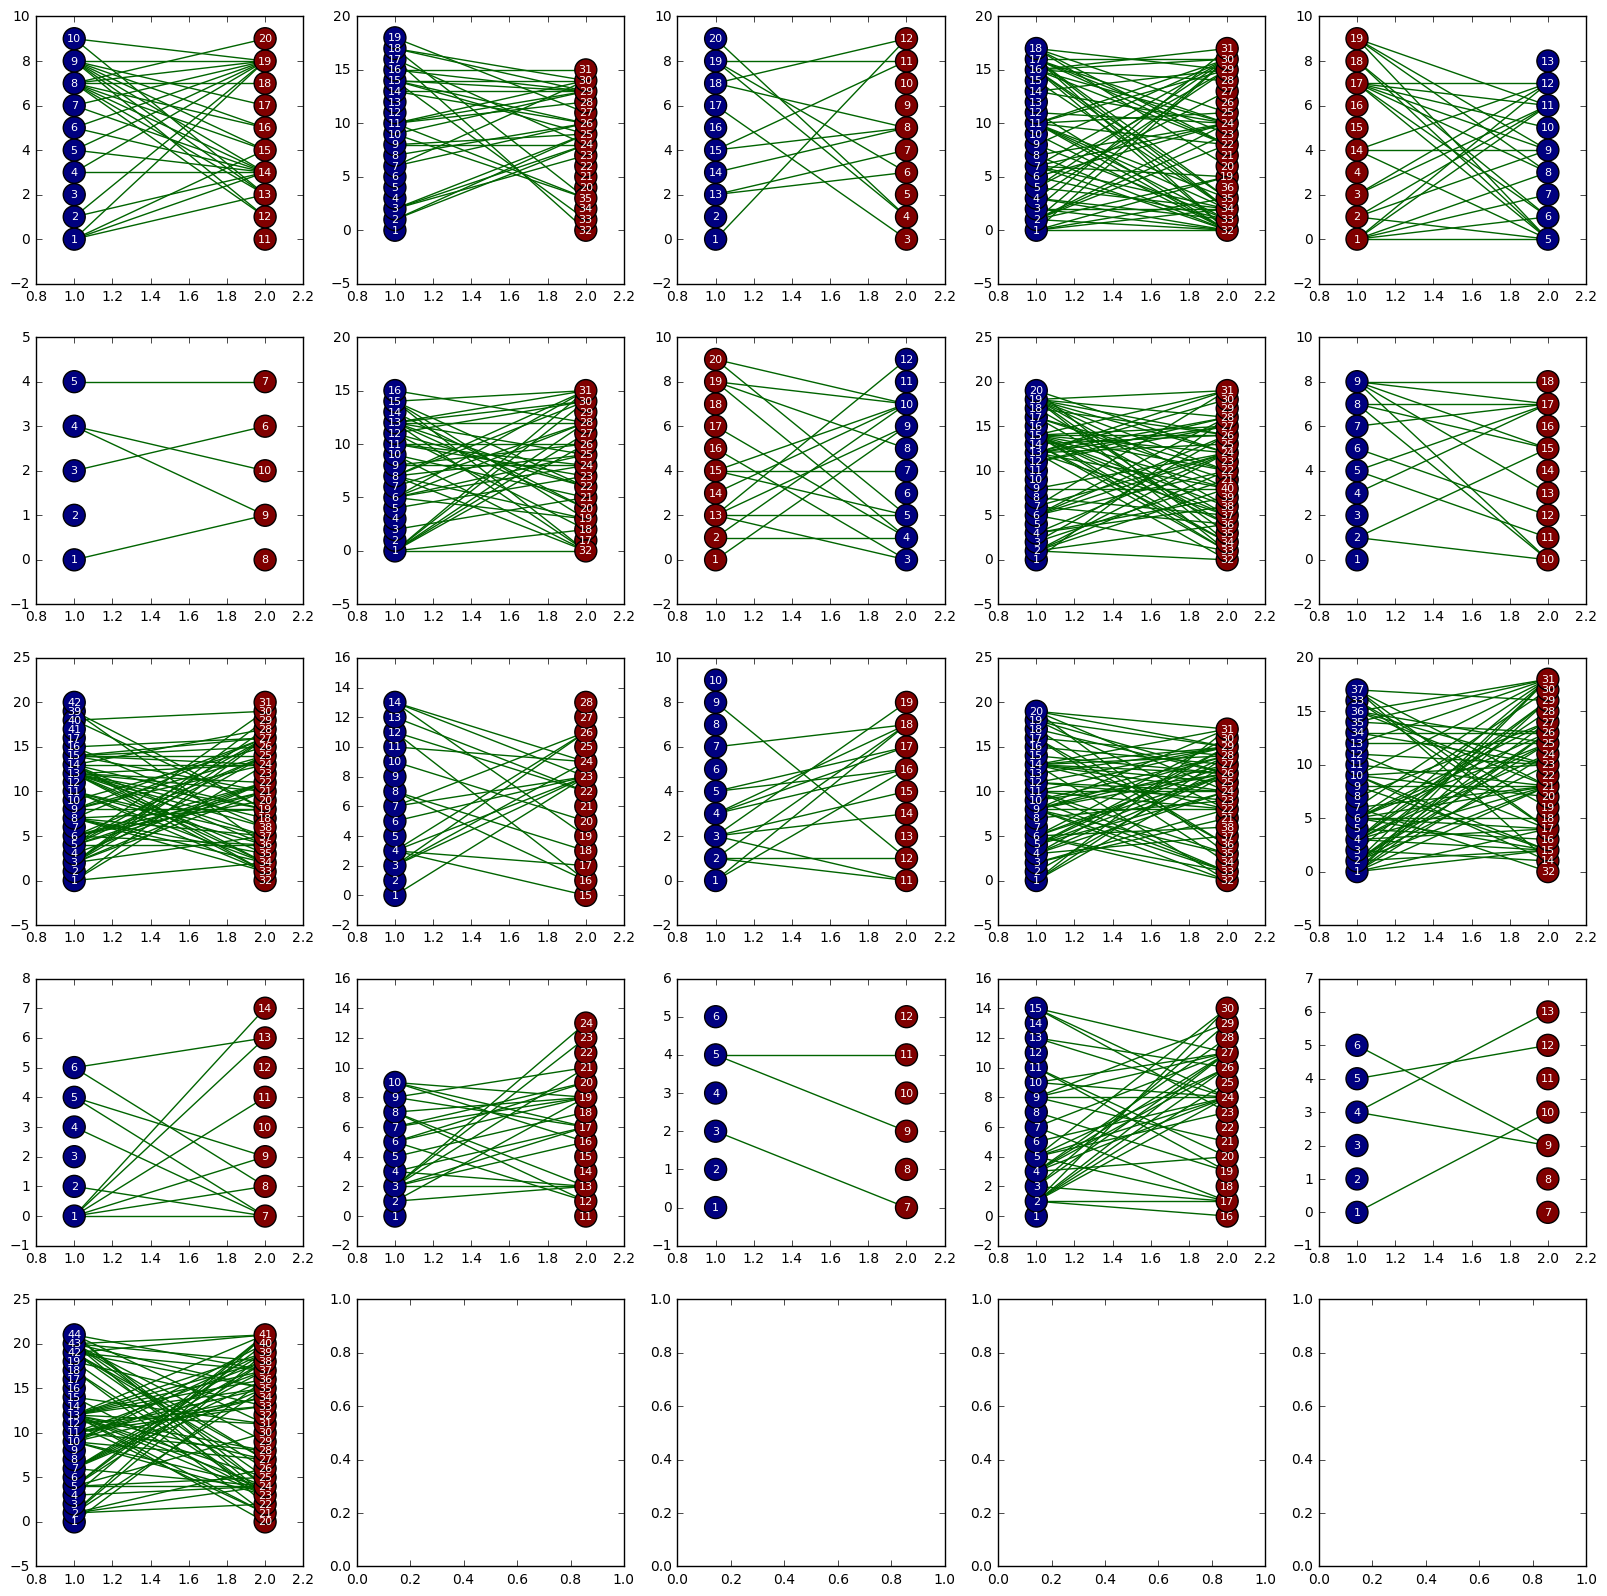

In [4]:
# Visualize the actual networks
f, axs = plt.subplots(5,5,figsize=(20,20))

for i,_ in enumerate(graphs):
    G = graphs[i]

    # draw as bipartite graph
    X,Y = bipartite.sets(G) # X=females,Y=males
    pos = dict()
    pos.update( (n, (1, j)) for j, n in enumerate(X) ) # put nodes from X at x=1
    pos.update( (n, (2, j)) for j, n in enumerate(Y) ) # put nodes from Y at x=2

    # draw only edges where the two people matched
    matches = list()
    for u,v in G.edges():
        if G[u][v]['match'] == 1:
            matches.append( (u,v) )

    # get specified feature for each node
    feats = nx.get_node_attributes(G,'gender').values() # blue=female, red=male

    plt.subplot(5,5,i+1)
    nx.draw_networkx_nodes(G,pos,node_color=feats,node_size=250)
    nx.draw_networkx_labels(G,pos,font_color='white',font_size=8)
    nx.draw_networkx_edges(G,pos,edgelist=matches,edge_color='darkgreen')
    
plt.show() # display all the plots

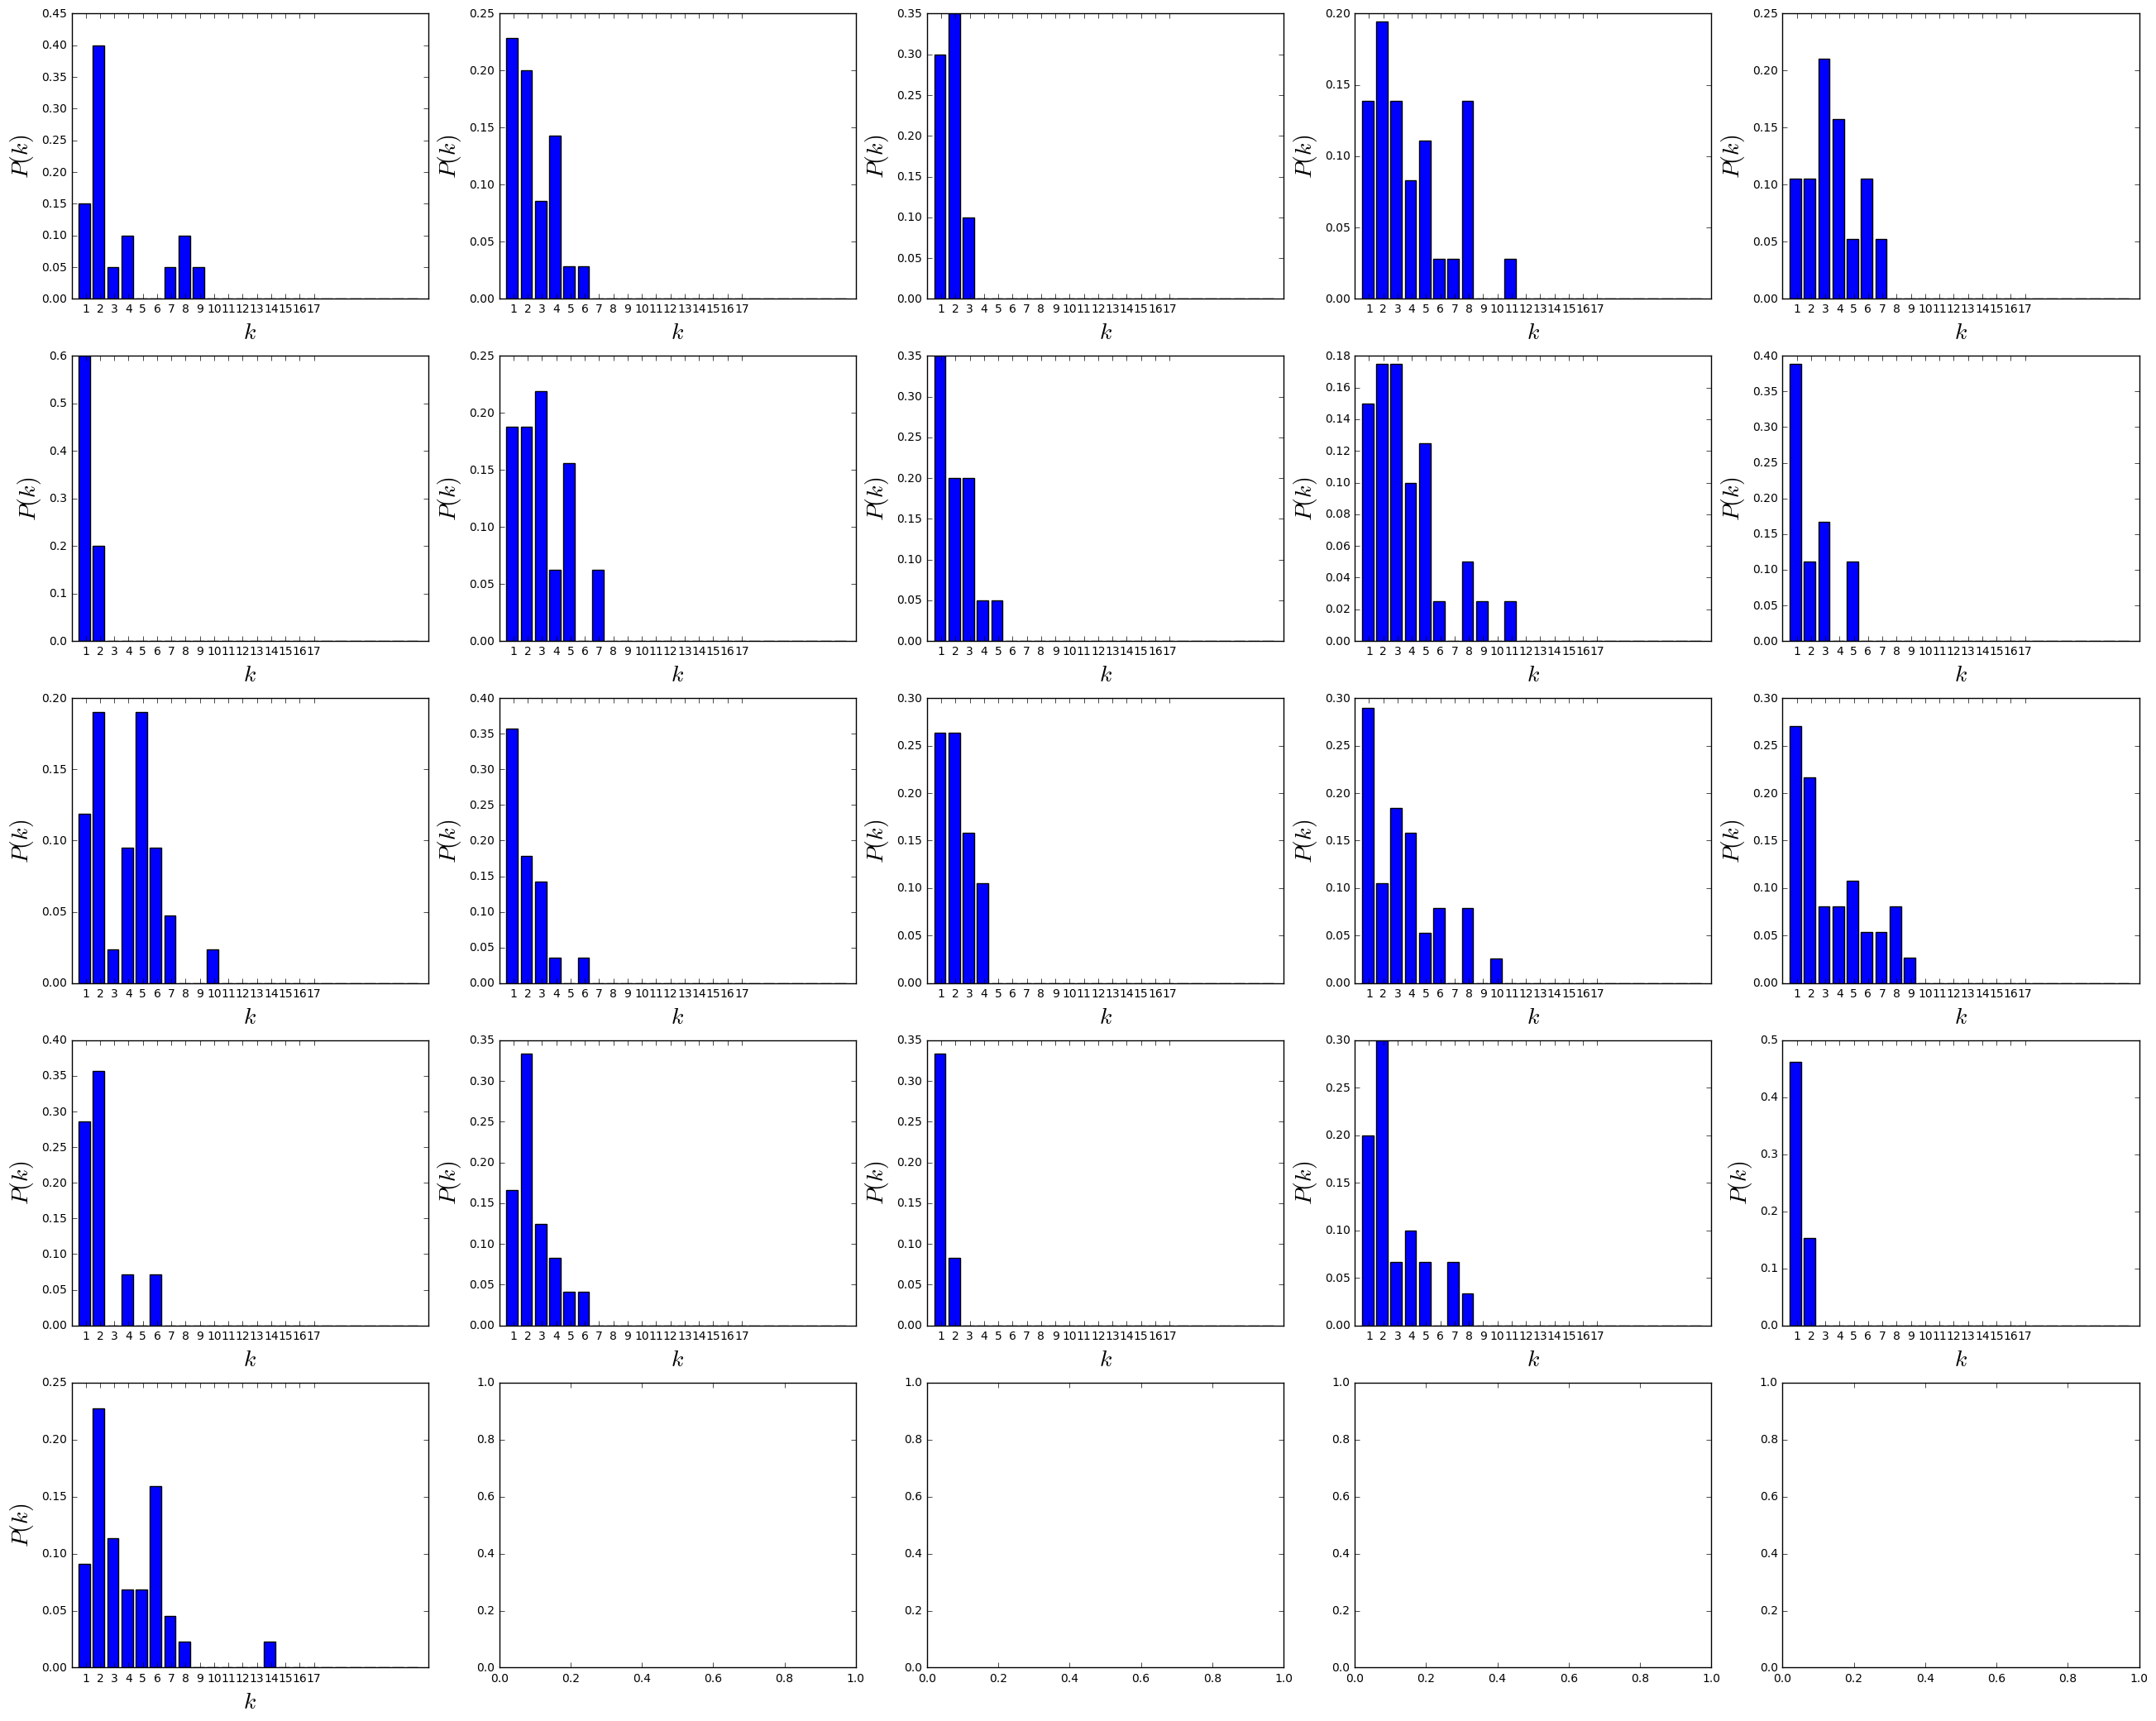

In [5]:
# Visualize the degree distributions for matches
f, axs = plt.subplots(5,5,figsize=(20,20))

# make graphs only have match edges now
for i,_ in enumerate(graphs):
    G = graphs[i]

    edges_to_remove = list()
    for u,v in G.edges():
        if G[u][v]['match'] == 0: 
            edges_to_remove.append( (u,v) )
            
    G.remove_edges_from(edges_to_remove)

    # graph values
    degree_values=np.array(nx.degree(G).values())
    N=nx.number_of_nodes(G)

    # histogram
    bins=np.arange(0.5,25.5)
    deg_k=np.histogram(degree_values,bins=bins)

    # degree distribution
    P_k=deg_k[0]/np.float(N)

    # plot
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(left=1,bottom=2,right=2.25,top=3) # for axis labels
    plt.bar(bins[:-1],P_k)
    plt.xticks(np.arange(1,18))
    plt.xlabel(r'$k$',fontsize=20)
    plt.ylabel(r'$P(k)$',fontsize=20)

plt.show() # display all the plots

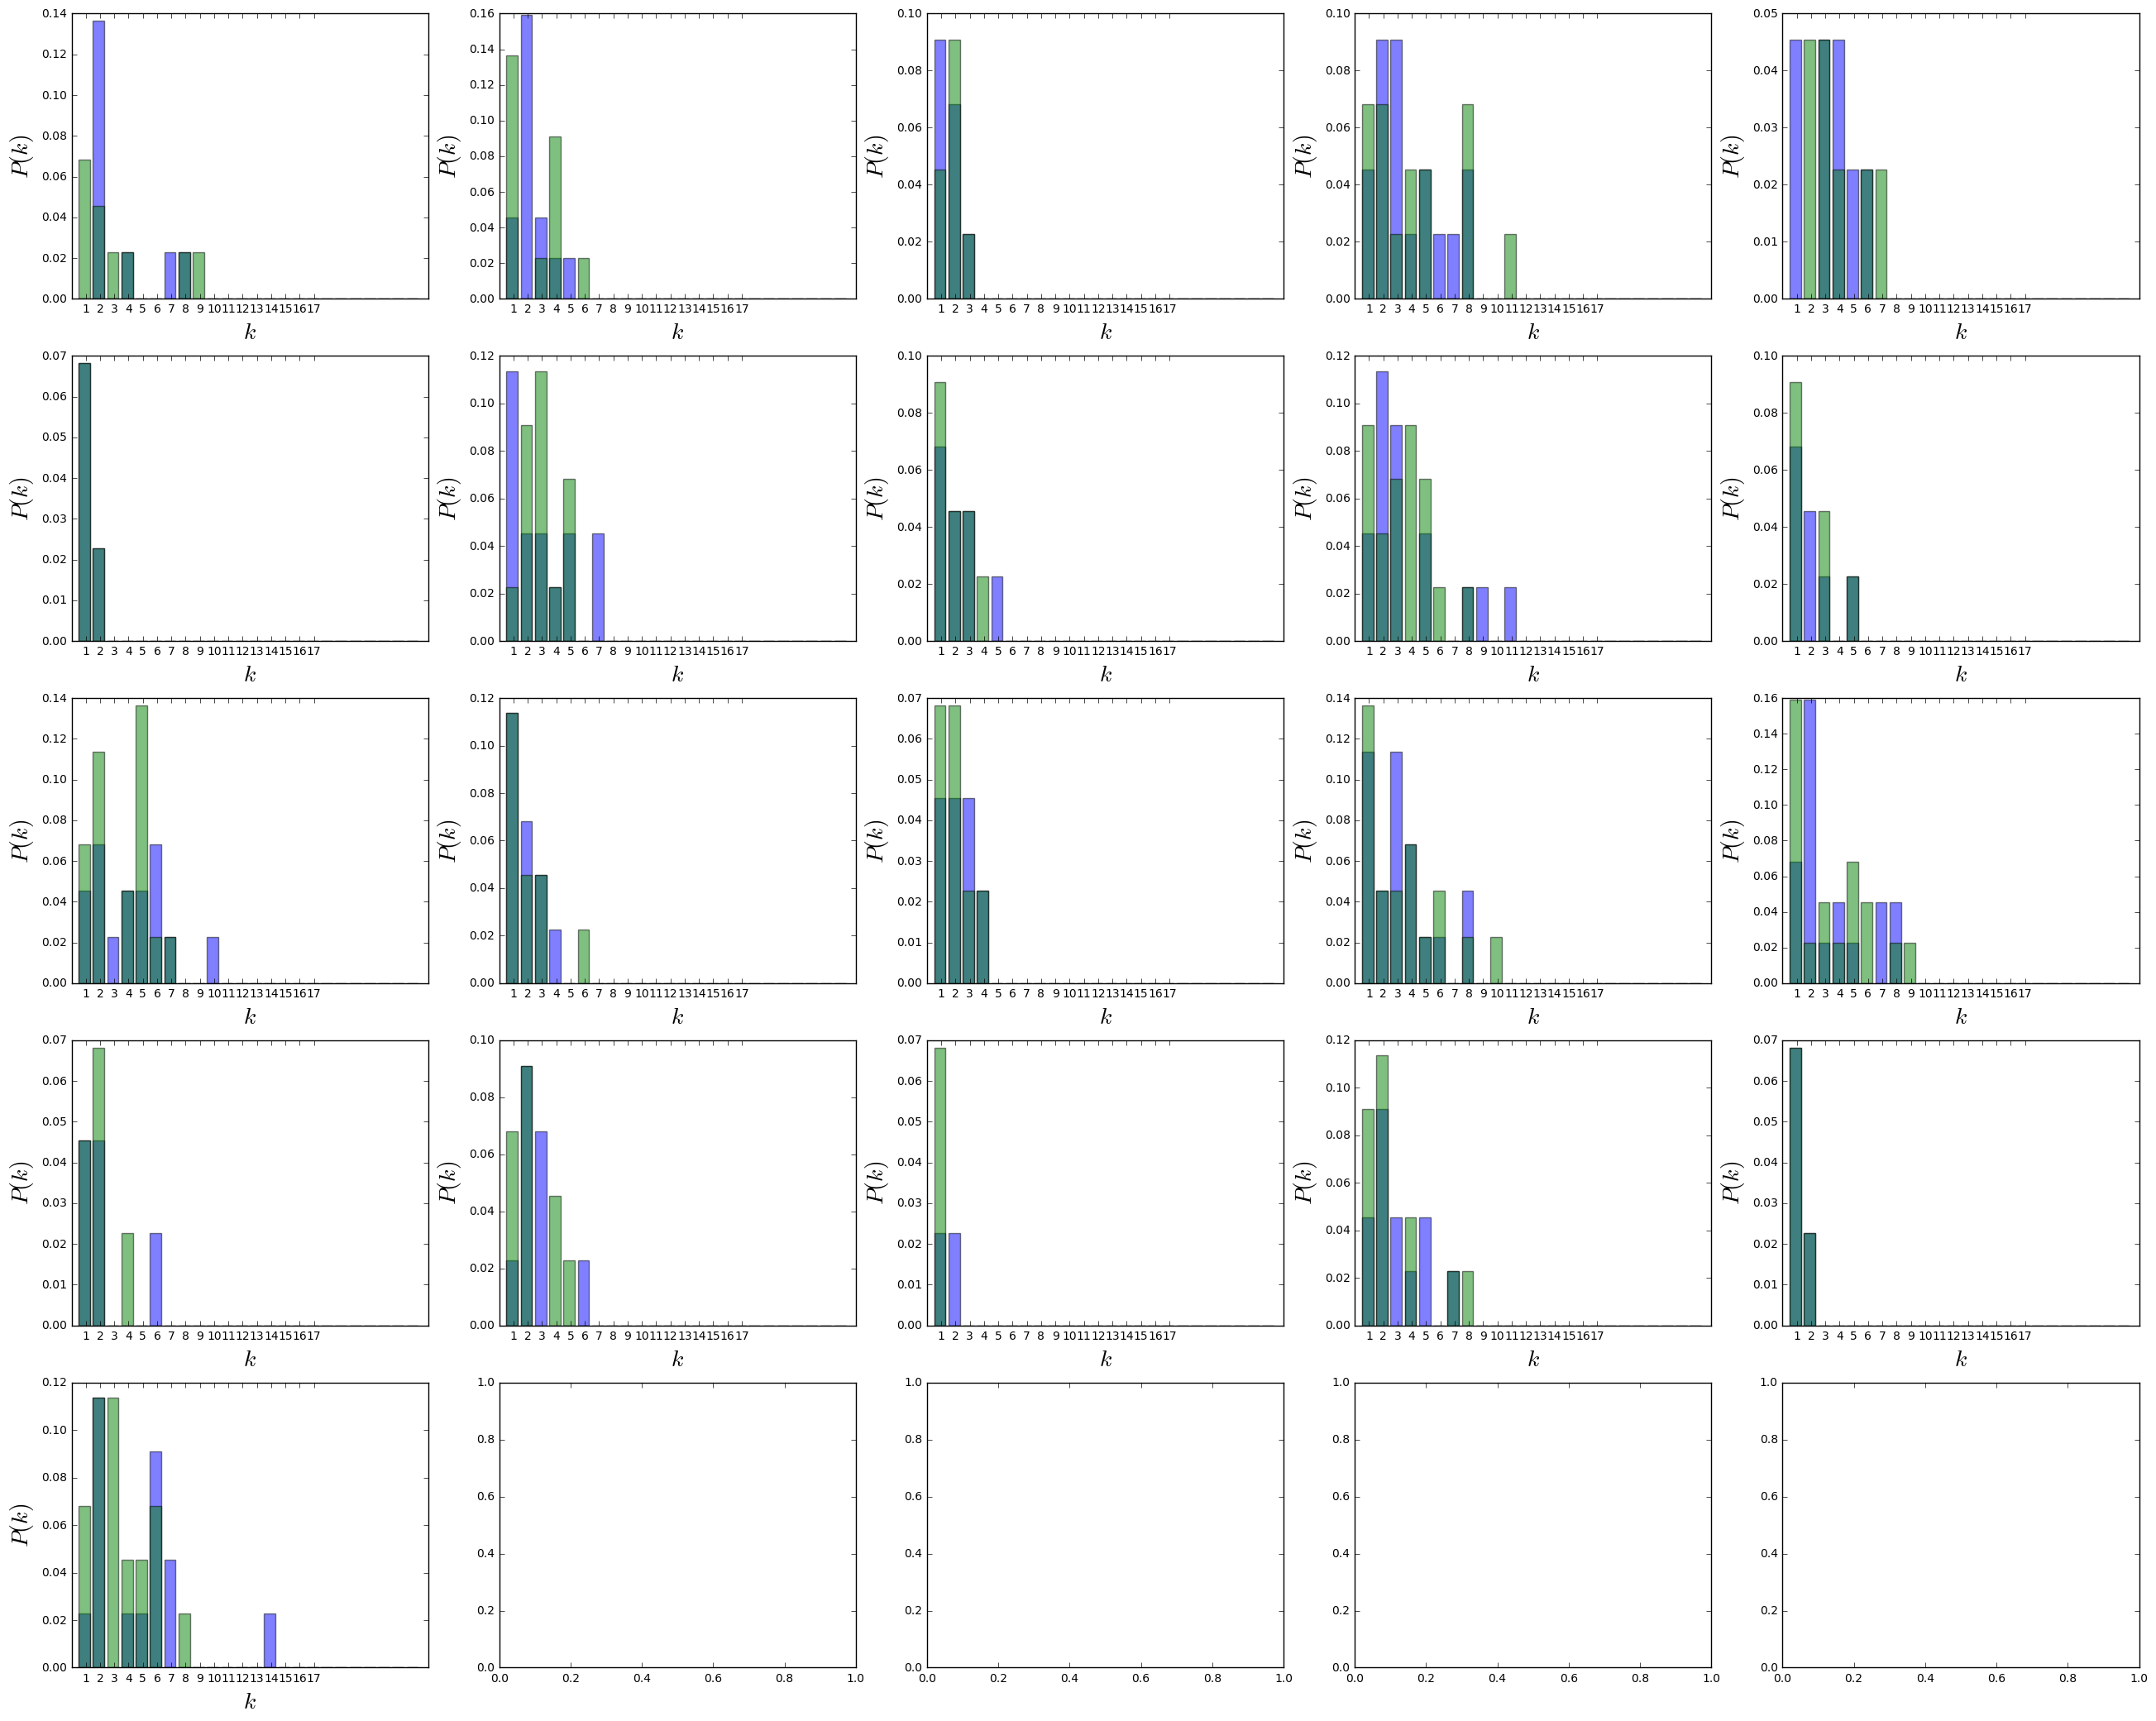

In [6]:
# Visualize the degree distributions for matches by gender
f, axs = plt.subplots(5,5,figsize=(20,20))

# make graphs only have match edges now
for i,_ in enumerate(graphs):
    G = graphs[i]

    edges_to_remove = list()
    for u,v in G.edges():
        if G[u][v]['match'] == 0: 
            edges_to_remove.append( (u,v) )
            
    G.remove_edges_from(edges_to_remove)
    
    # want to draw distributions by gender
    genders = nx.get_node_attributes(G,'gender')
    males = list(k for k, v in genders.iteritems() if v == 1)
    females = list(k for k, v in genders.iteritems() if v == 0)
    N_male = len(males); N_female = len(females)

    # graph values
    degrees = nx.degree(G); female_degree_values = list(); male_degree_values = list()
    for n,d in degrees.iteritems():
        if n in females: female_degree_values.append(d)
        else: male_degree_values.append(d) # only two options

    # histogram
    bins = np.arange(0.5,25.5)
    deg_k_female = np.histogram(female_degree_values,bins=bins)
    deg_k_male = np.histogram(male_degree_values,bins=bins)

    # degree distribution
    P_k_female = deg_k_female[0]/np.float(N)
    P_k_male = deg_k_male[0]/np.float(N)

    # plot
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(left=1,bottom=2,right=2.25,top=3) # for axis labels
    plt.bar(bins[:-1],P_k_female,color='blue',alpha=0.5)
    plt.bar(bins[:-1],P_k_male,color='green',alpha=0.5)
    plt.xticks(np.arange(1,18))
    plt.xlabel(r'$k$',fontsize=20)
    plt.ylabel(r'$P(k)$',fontsize=20)

plt.show() # display all the plots

In [ ]:
# balanced triads by:



In [3]:
# create directed graphs of decisions

# node features of import
node_feat = ['gender', 'field_cd', 'career_c']

# create graphs for each wave
waves = df['wave'].unique()
graphs = list()

# graphs for each wave of decisions
for w in waves:
    dta = df.loc[df['wave'] == w]
    # TODO: figure out what other edge attributes to include
    G = nx.from_pandas_dataframe(dta,'iid','pid',edge_attr=['dec','samerace','int_corr'],create_using=nx.DiGraph())
    
    # set node attributes
    # TODO: figure out what other node attributes to include
    for a in node_feat:
        feat = dta[['iid',a]]
        feat = feat.set_index('iid').T.to_dict('records')[0] # convert to dictionary
        nx.set_node_attributes(G,a,feat)
    
    G = nx.convert_node_labels_to_integers(G,first_label=1)
    graphs.append(G)

/usr/local/lib/python2.7/site-packages/pandas/core/frame.py:840: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  "columns will be omitted.", UserWarning)


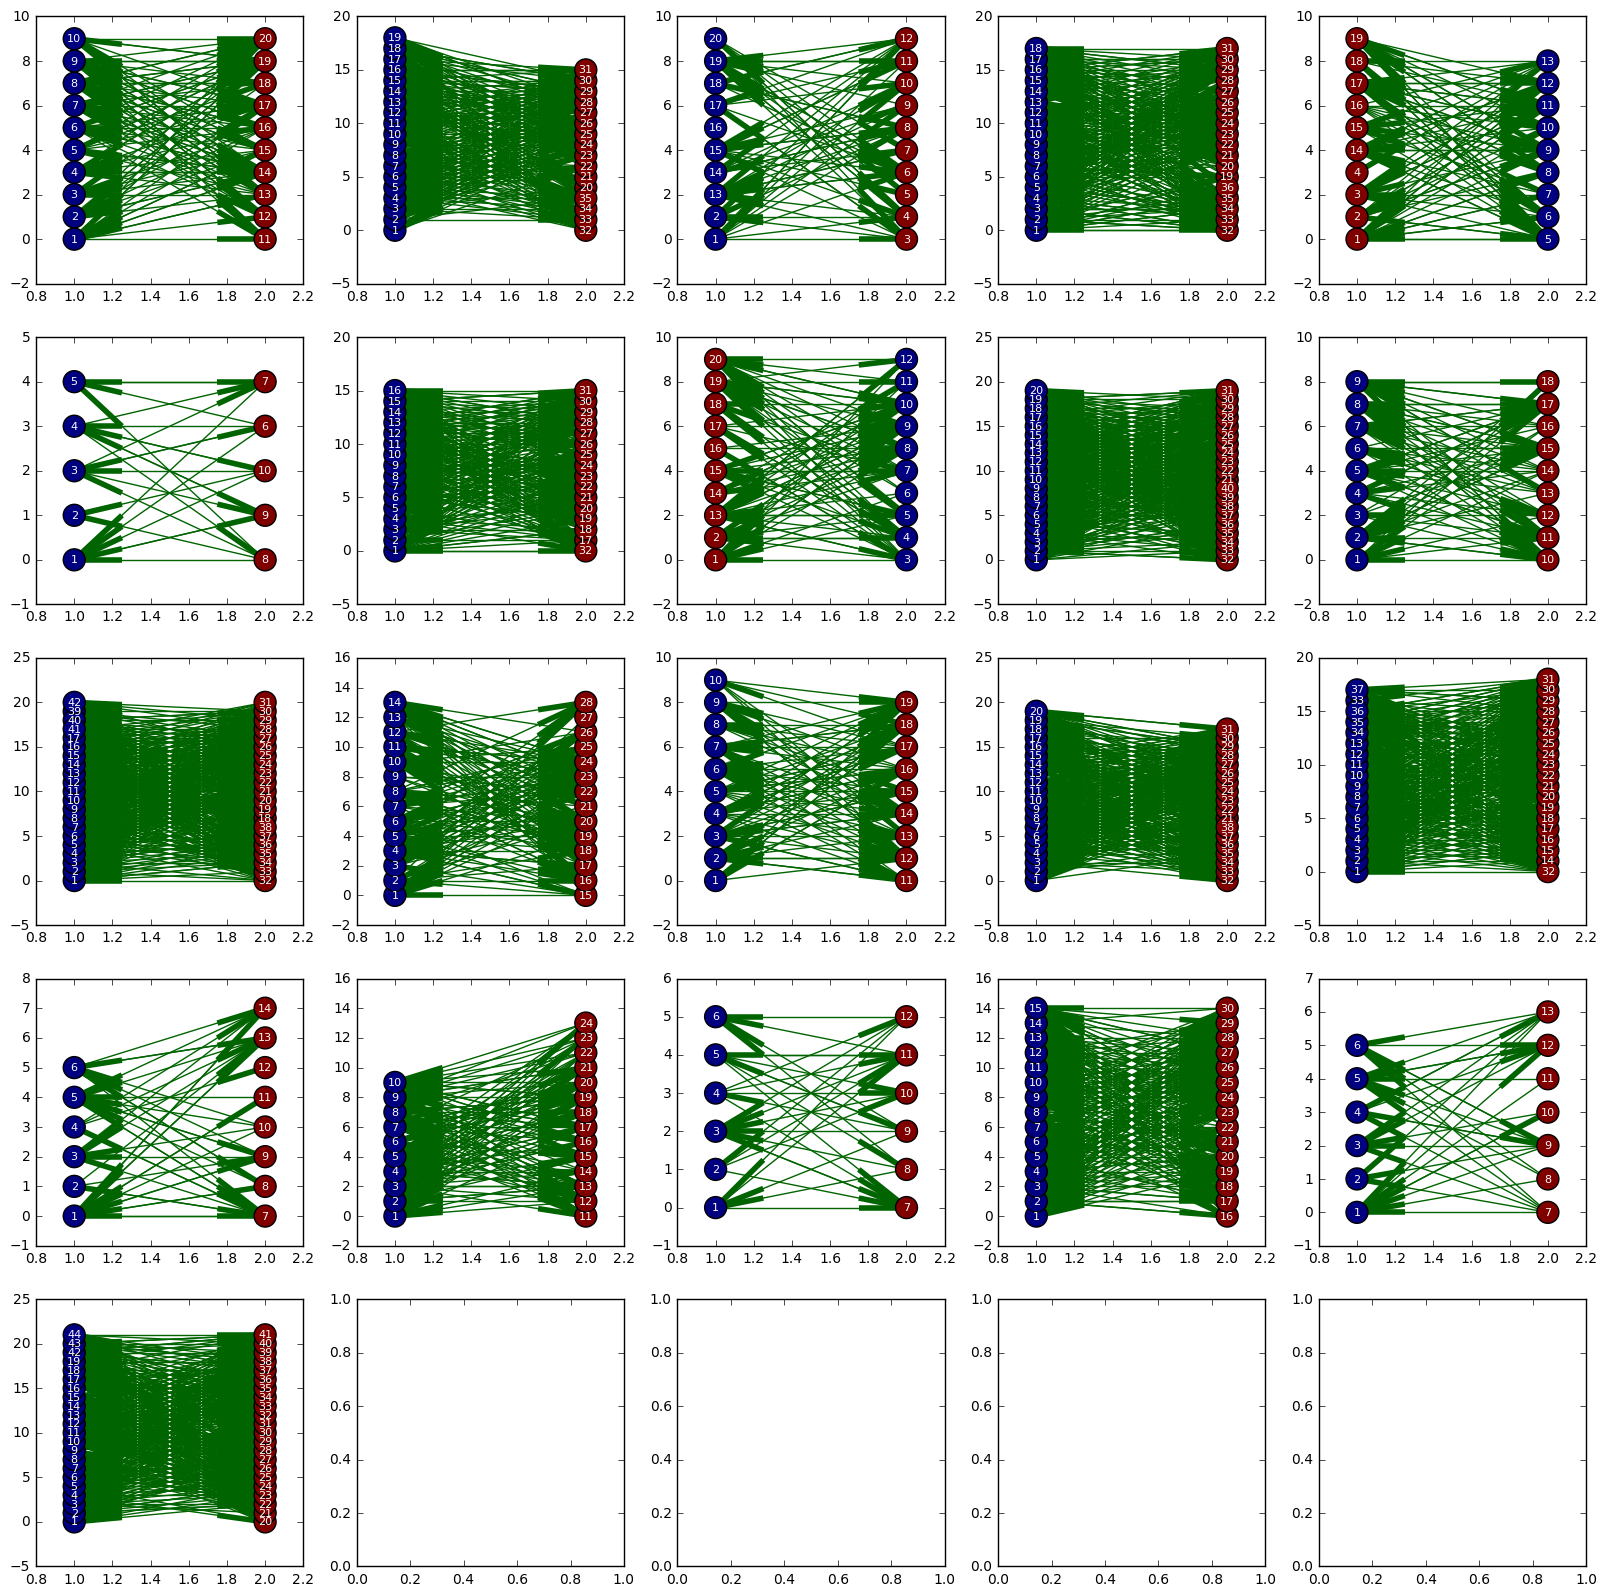

In [5]:
# Visualize the actual networks
f, axs = plt.subplots(5,5,figsize=(20,20))

# CHECK THIS IT SEEMS WRONG

for i,_ in enumerate(graphs):
    G = graphs[i]

    # draw as bipartite graph
    X,Y = bipartite.sets(G)
    pos = dict()
    pos.update( (n, (1, j)) for j, n in enumerate(X) ) # put nodes from X at x=1
    pos.update( (n, (2, j)) for j, n in enumerate(Y) ) # put nodes from Y at x=2

    # draw only edges where the person decided Y
    decisions = list()
    for u,v in G.edges():
        if G[u][v]['dec'] == 1:
            decisions.append( (u,v) )

    # get specified feature for each node
    feats = nx.get_node_attributes(G,'gender').values()

    plt.subplot(5,5,i+1)
    nx.draw_networkx_nodes(G,pos,node_color=feats,node_size=250)
    nx.draw_networkx_labels(G,pos,font_color='white',font_size=8)
    nx.draw_networkx_edges(G,pos,edgelist=decisions,edge_color='darkgreen')
    
plt.show() # display all the plots

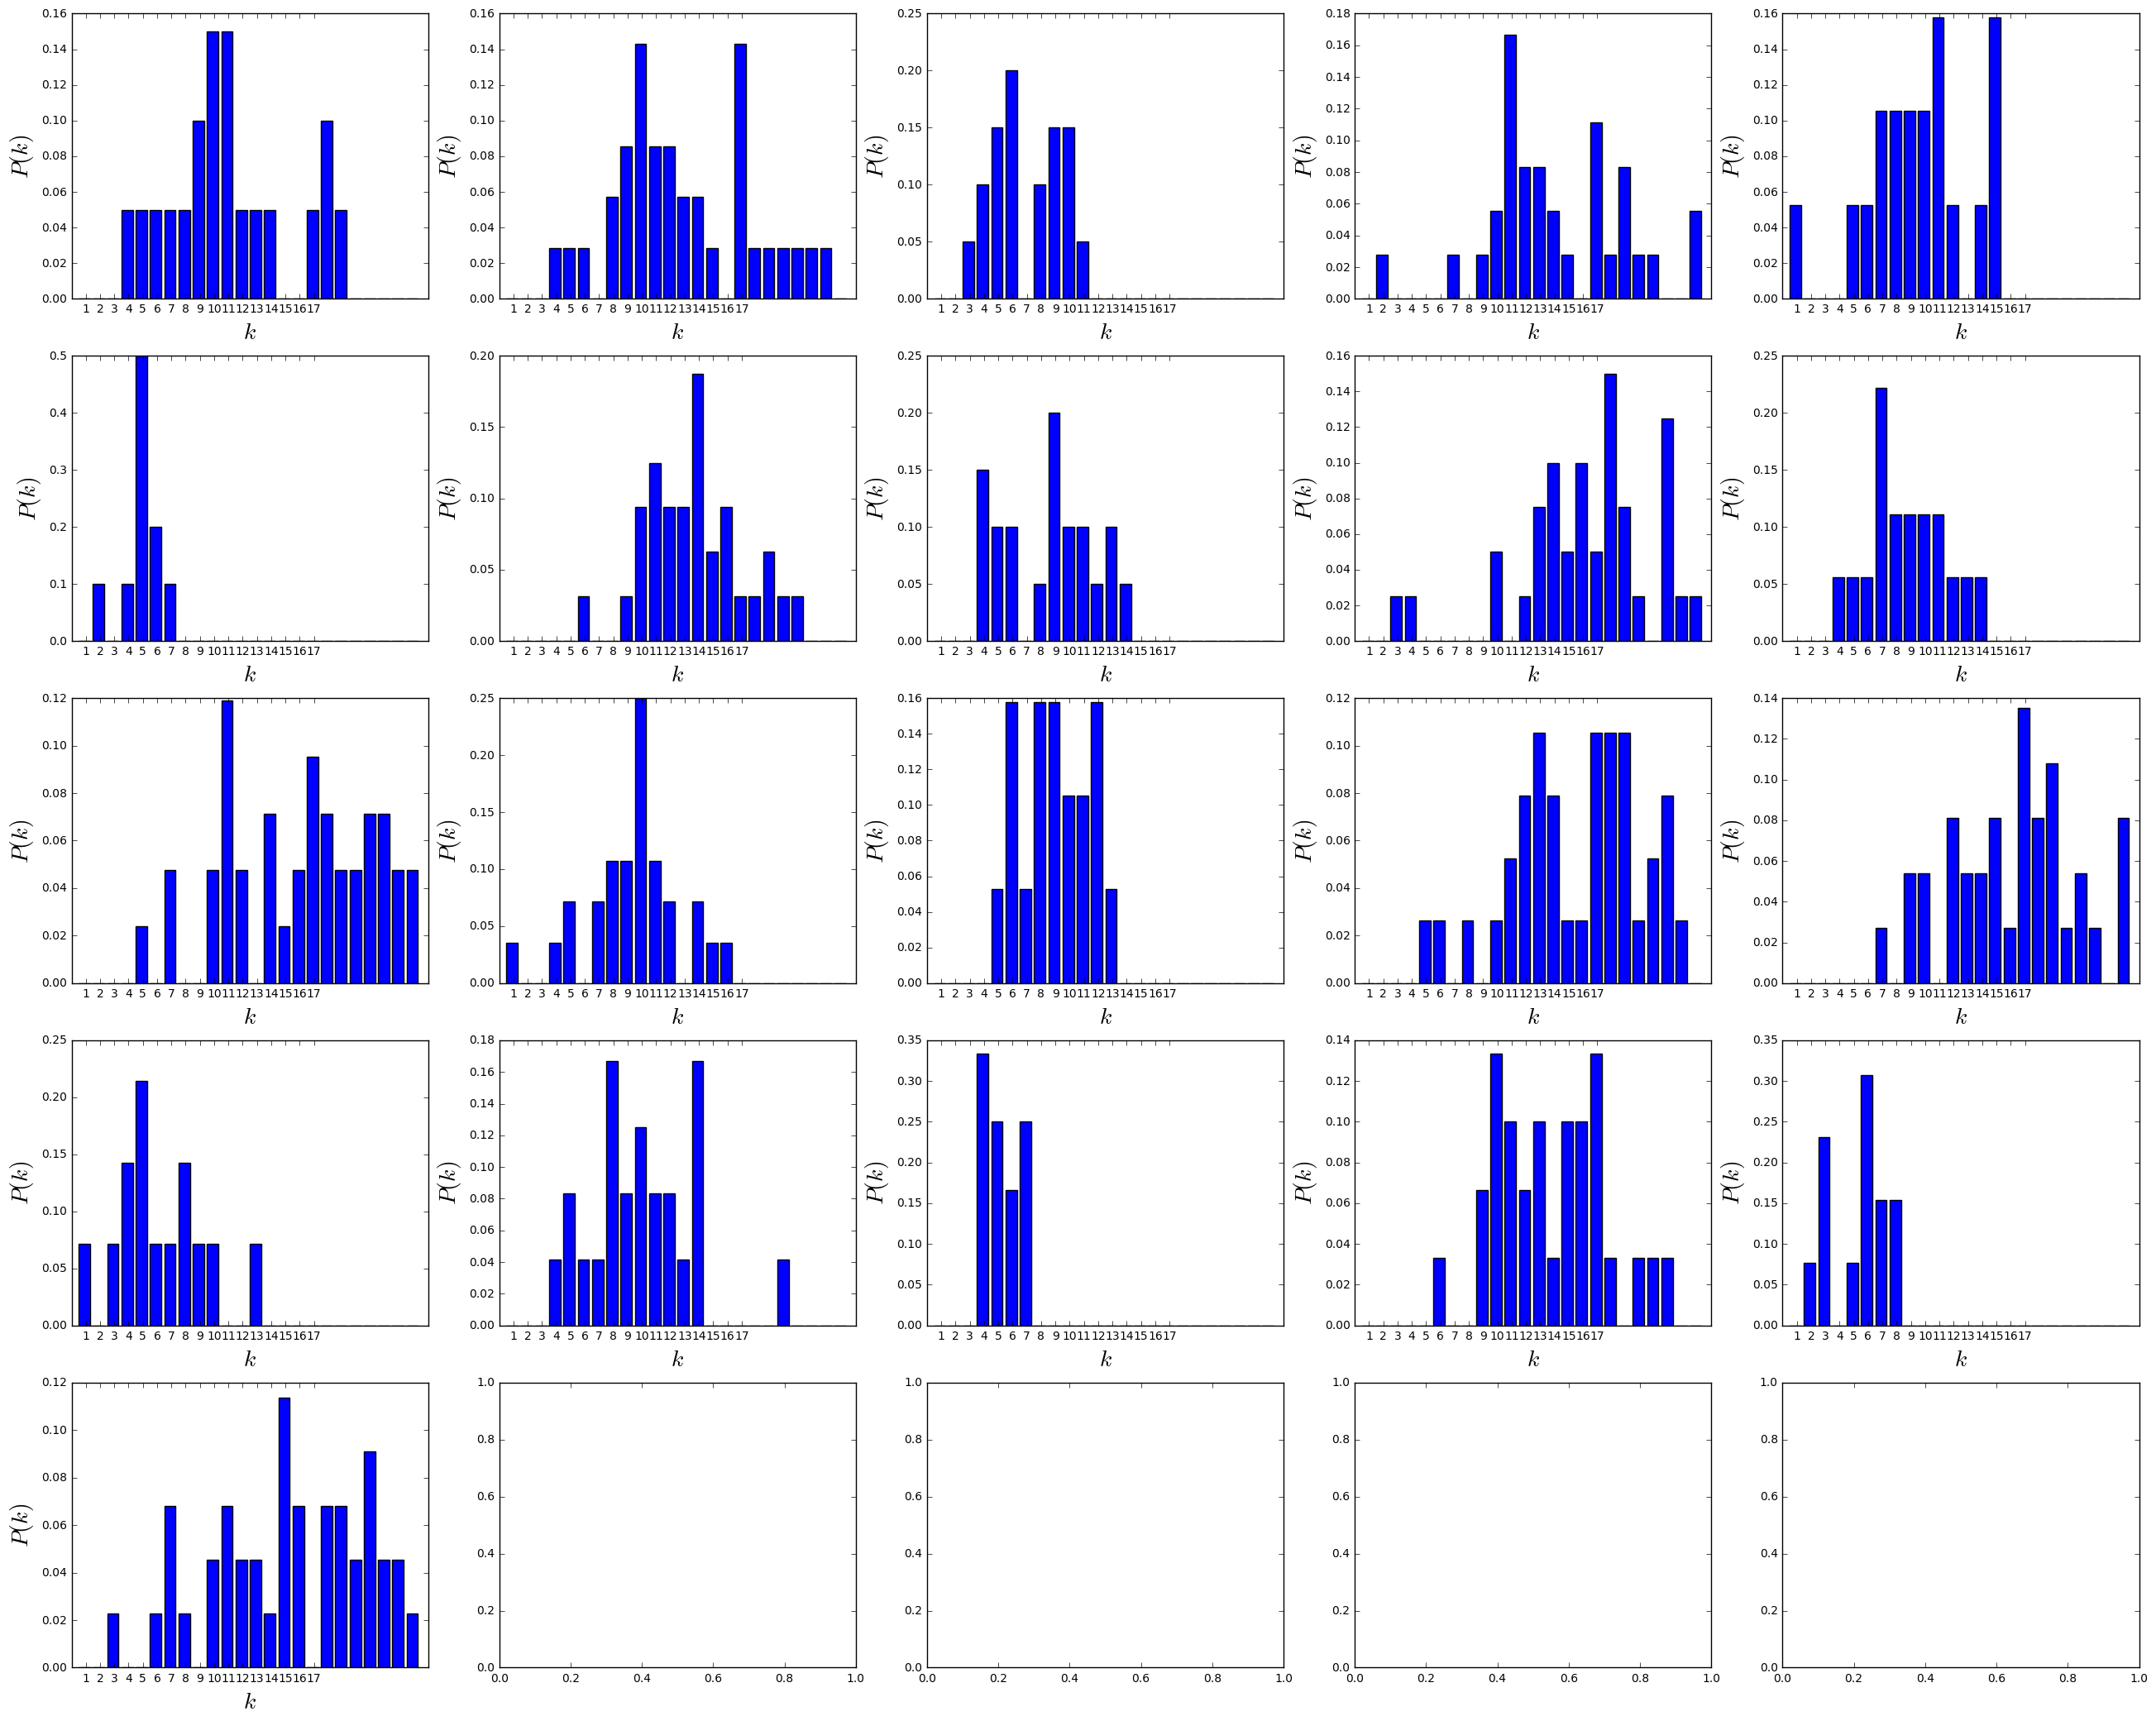

In [9]:
# Visualize the degree distributions
f, axs = plt.subplots(5,5,figsize=(20,20))

# make graphs only have decision edges now
for i,_ in enumerate(graphs):
    G = graphs[i]

    edges_to_remove = list()
    for u,v in G.edges():
        if G[u][v]['dec'] == 0: 
            edges_to_remove.append( (u,v) )
            
    G.remove_edges_from(edges_to_remove)

    # graph values
    degree_values=np.array(nx.degree(G).values())
    N=nx.number_of_nodes(G)

    # histogram
    bins=np.arange(0.5,25.5)
    deg_k=np.histogram(degree_values,bins=bins)

    # degree distribution
    P_k=deg_k[0]/np.float(N)

    # plot
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(left=1,bottom=2,right=2.25,top=3) # for axis labels
    plt.bar(bins[:-1],P_k)
    plt.xticks(np.arange(1,18))
    plt.xlabel(r'$k$',fontsize=20)
    plt.ylabel(r'$P(k)$',fontsize=20)

plt.show() # display all the plots

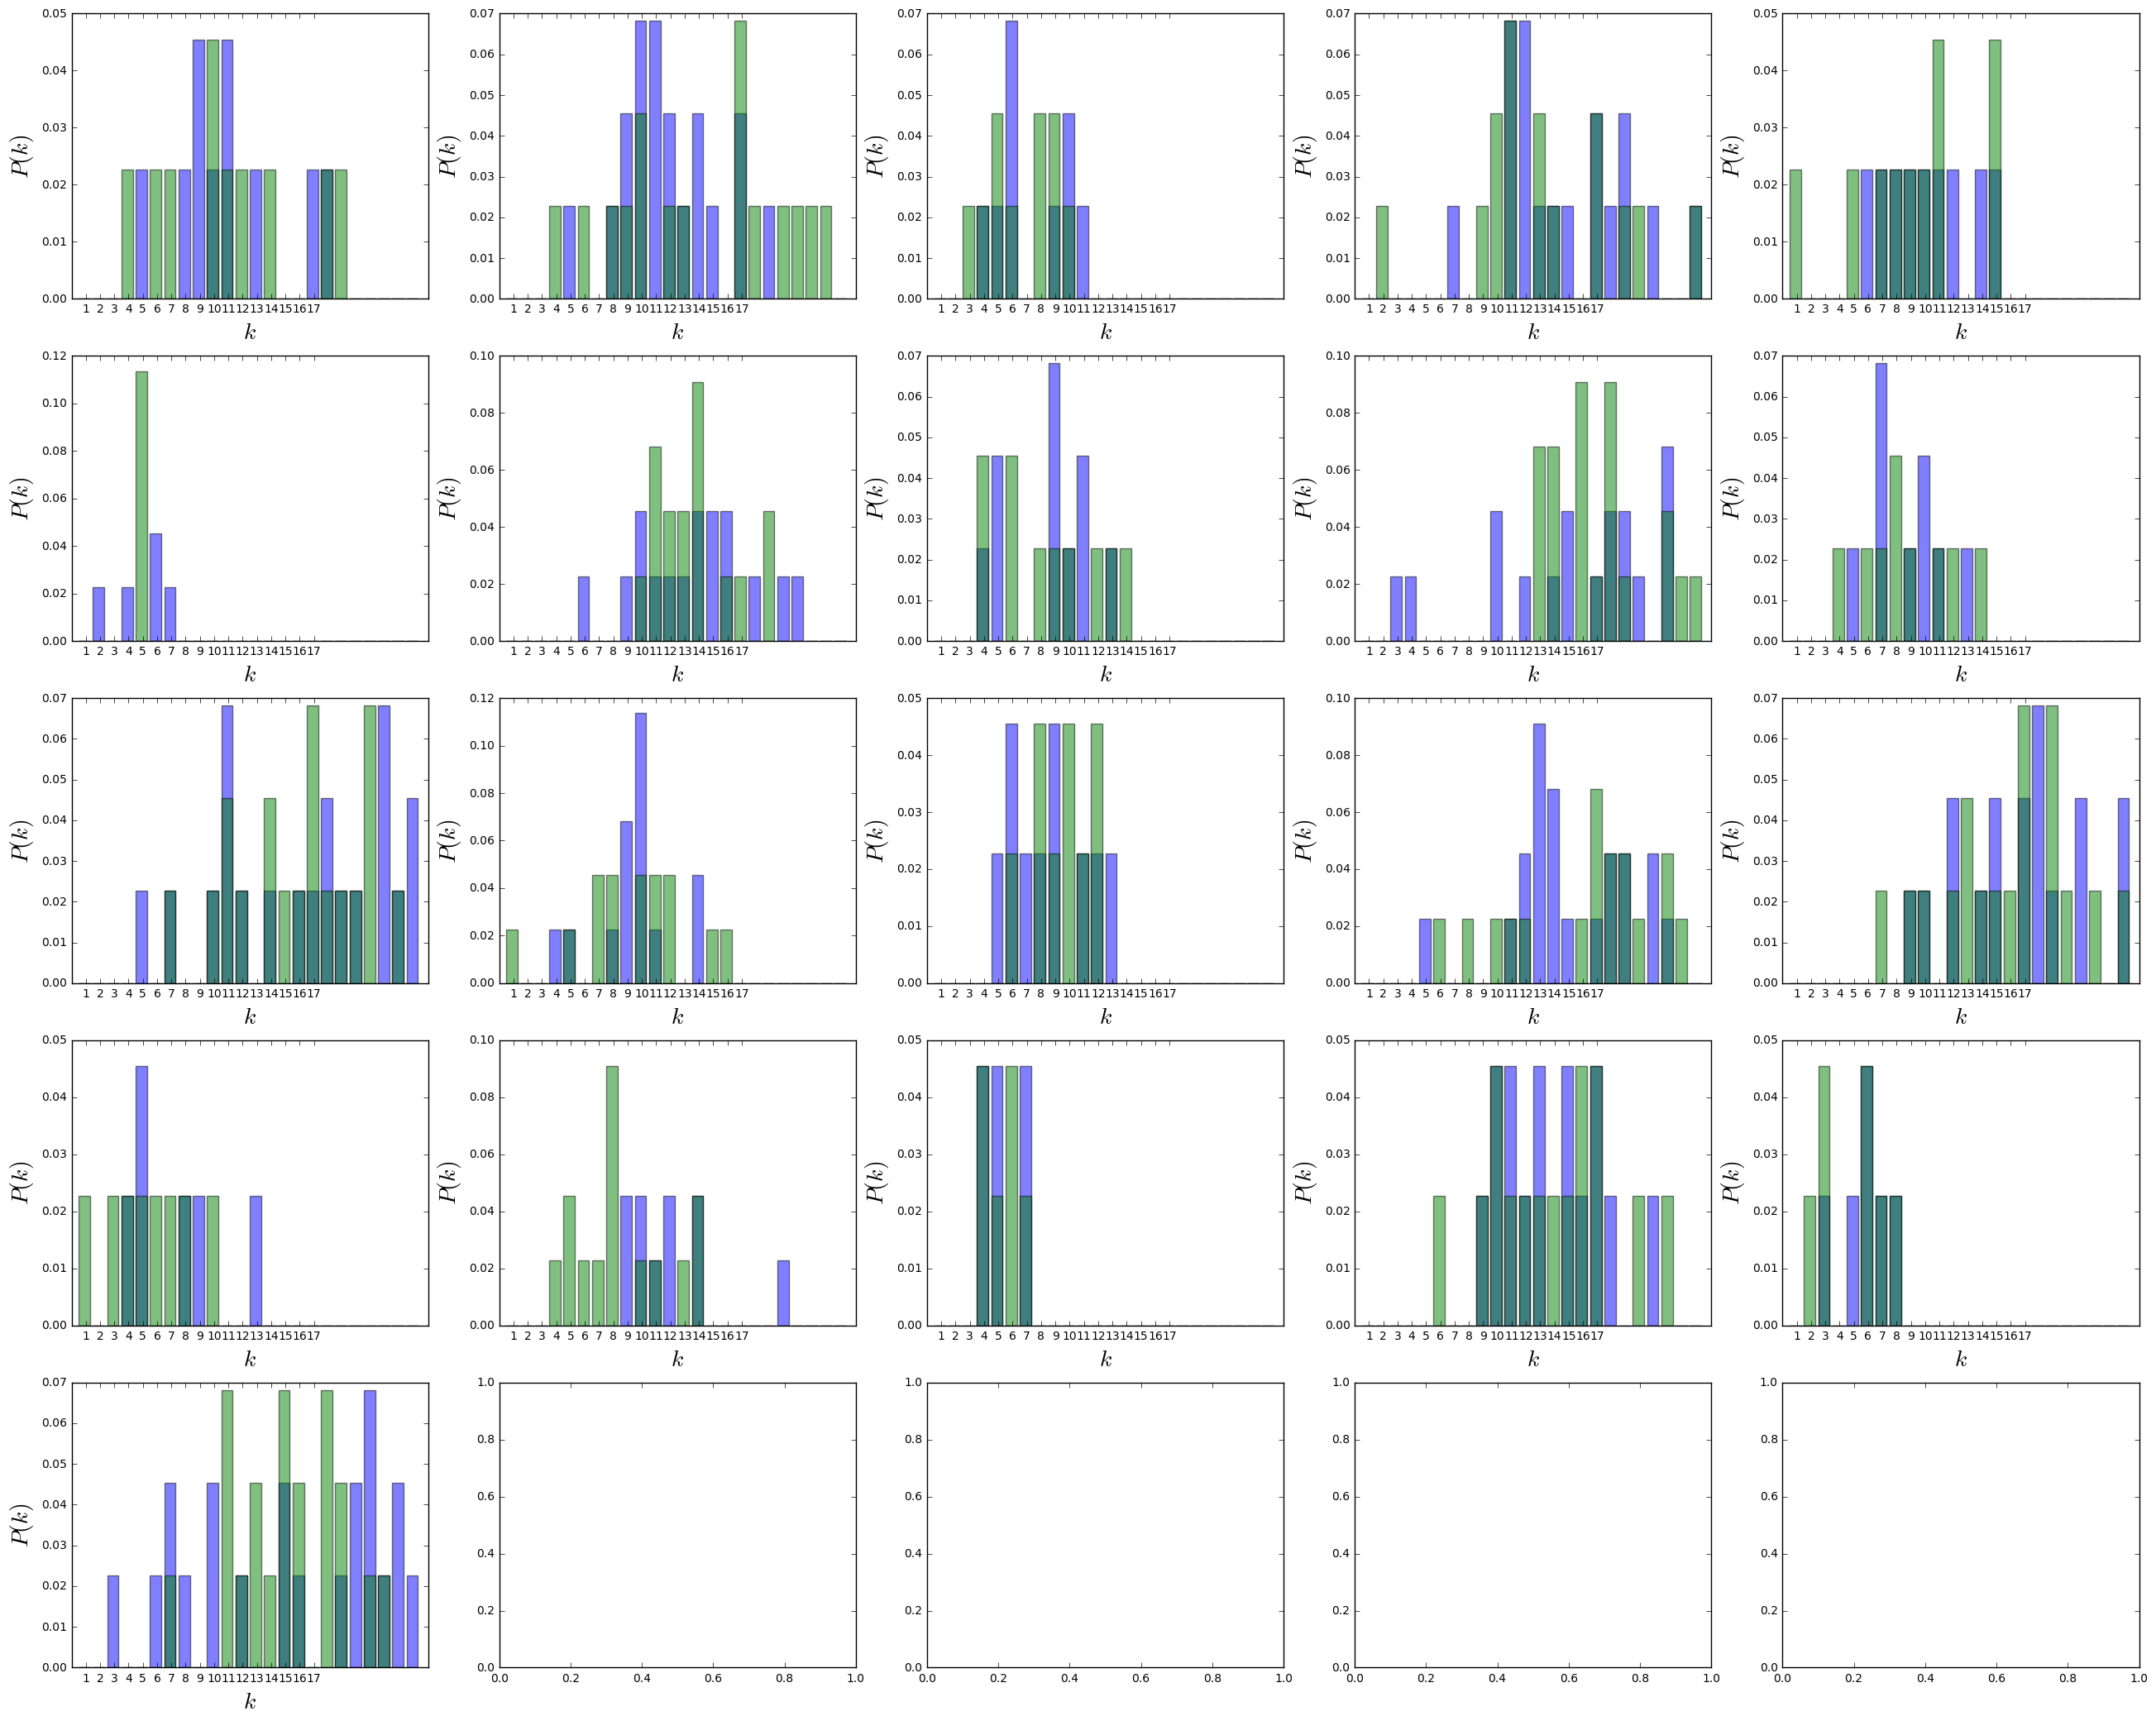

In [10]:
# Visualize the degree distributions for decisions by gender
f, axs = plt.subplots(5,5,figsize=(20,20))

# make graphs only have decision edges now
for i,_ in enumerate(graphs):
    G = graphs[i]

    edges_to_remove = list()
    for u,v in G.edges():
        if G[u][v]['dec'] == 0: 
            edges_to_remove.append( (u,v) )
            
    G.remove_edges_from(edges_to_remove)
    
    # want to draw distributions by gender
    genders = nx.get_node_attributes(G,'gender')
    males = list(k for k, v in genders.iteritems() if v == 1)
    females = list(k for k, v in genders.iteritems() if v == 0)
    N_male = len(males); N_female = len(females)

    # graph values
    degrees = nx.degree(G); female_degree_values = list(); male_degree_values = list()
    for n,d in degrees.iteritems():
        if n in females: female_degree_values.append(d)
        else: male_degree_values.append(d) # only two options

    # histogram
    bins = np.arange(0.5,25.5)
    deg_k_female = np.histogram(female_degree_values,bins=bins)
    deg_k_male = np.histogram(male_degree_values,bins=bins)

    # degree distribution
    P_k_female = deg_k_female[0]/np.float(N)
    P_k_male = deg_k_male[0]/np.float(N)

    # plot
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(left=1,bottom=2,right=2.25,top=3) # for axis labels
    plt.bar(bins[:-1],P_k_female,color='blue',alpha=0.5)
    plt.bar(bins[:-1],P_k_male,color='green',alpha=0.5)
    plt.xticks(np.arange(1,18))
    plt.xlabel(r'$k$',fontsize=20)
    plt.ylabel(r'$P(k)$',fontsize=20)

plt.show() # display all the plots

In [ ]:
# balanced triads by:



In [6]:
# Generate networks connecting participants to categorical variables
# potential categorical variables of interest: field/field_cd, undergrad/mn_sat/tuition, race,
#   from/zipcode/income, career/career_c, 
# TODO: update and explore the above list

# create graphs for each field
fields = df['field'].unique(); fields = np.delete(fields,10) # remove nan values
graphs = list()

# graphs for each field
for f in fields:
    dta = df.loc[df['field'] == f]
    G = nx.from_pandas_dataframe(dta,'iid','field',create_using=nx.DiGraph())
    
    # add node attributes
    sizes = dict(); types = dict()
    for n in G:
        if n in fields: sizes[n] = 10; types[n] = 1
        else: sizes[n] = 1; types[n] = 0
    nx.set_node_attributes(G,'size',sizes)
    nx.set_node_attributes(G,'type',types)
    
    # add connections between people
    ids = dta['id']
    for _,r in dta.iterrows():
        if r['iid'] in G and r['pid'] in G and r['dec'] == 1: 
            G.add_edge(r['iid'],r['pid'])
            
    # add edge attributes
    types = dict()
    for u,v in G.edges():
        if u in fields or v in fields: types[(u,v)] = 1 # person-focus
        else: types[(u,v)] = 2 # person to person w/in same category
    nx.set_edge_attributes(G,'type',types)
            
    graphs.append(G)

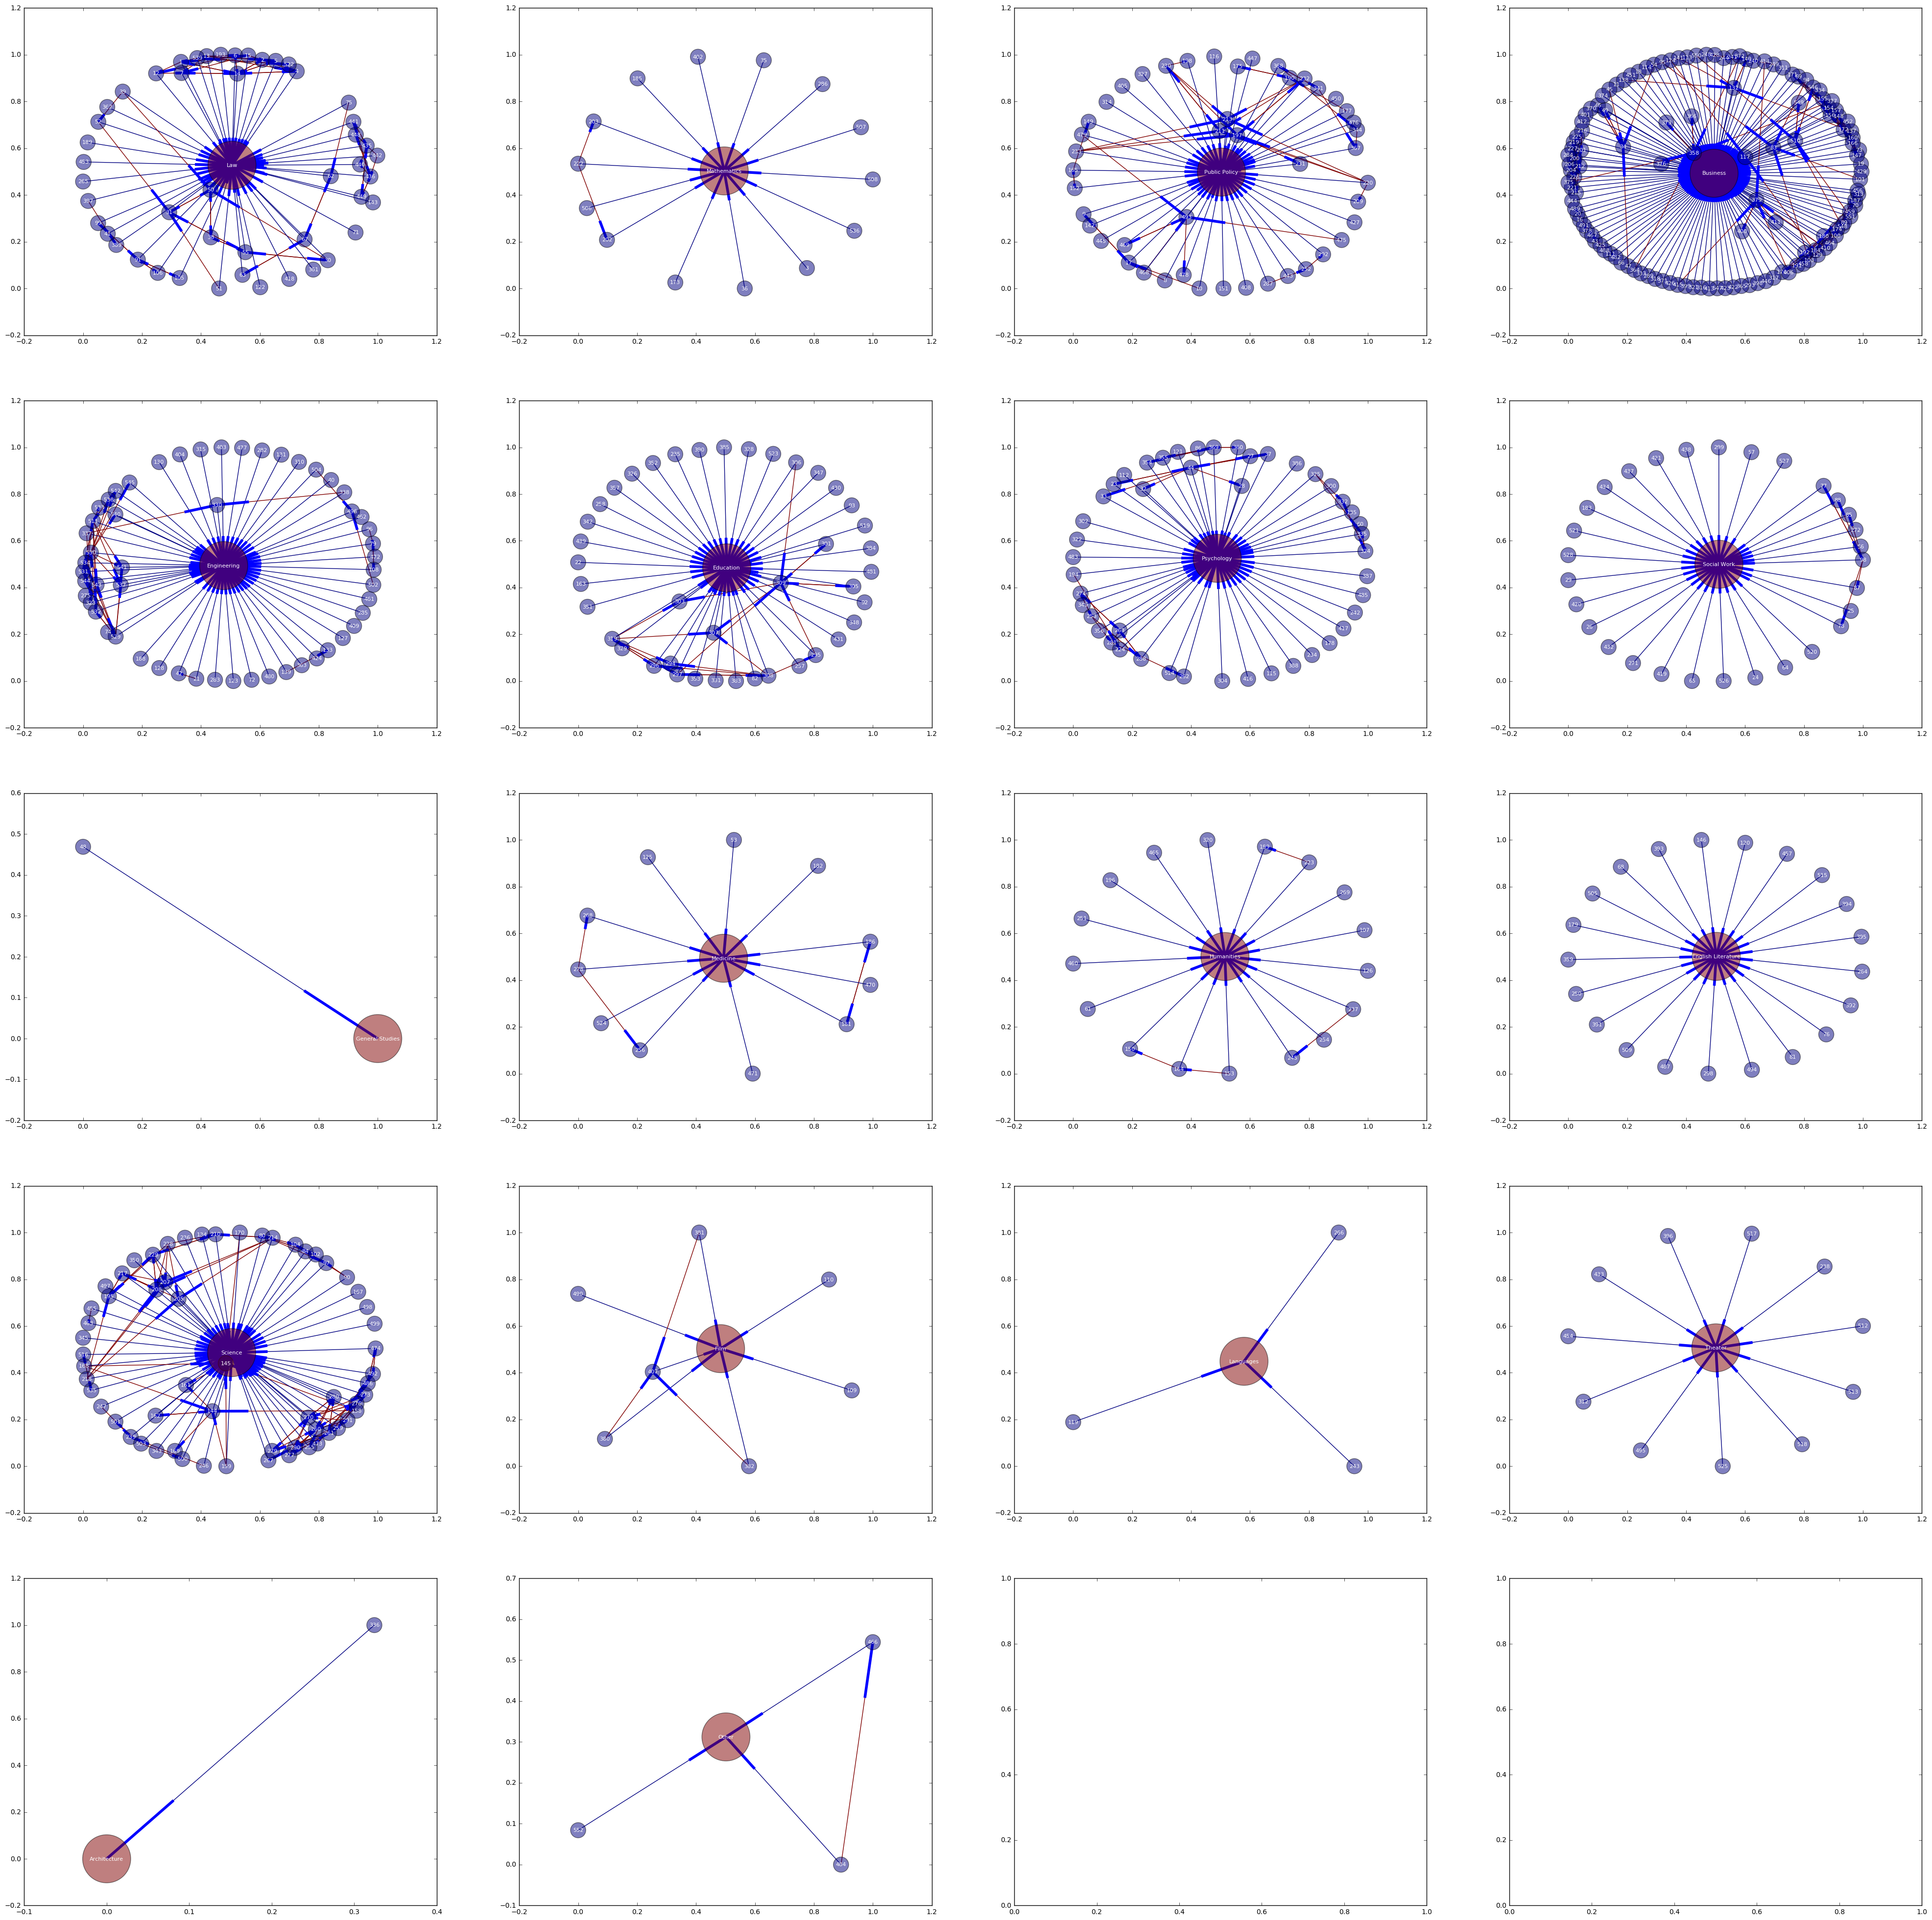

In [12]:
# Visualize the actual networks
f, axs = plt.subplots(5,4,figsize=(50,50))

for i,_ in enumerate(graphs):
    G = graphs[i]
    
    # in order to map degrees to nodes correctly
    node_list,node_sizes = zip(*nx.get_node_attributes(G,'size').items())
    node_sizes = np.array(node_sizes)
    
    # for color coding nodes and edges
    node_list,node_types = zip(*nx.get_node_attributes(G,'type').items())
    edge_list,edge_types = zip(*nx.get_edge_attributes(G,'type').items())
    
    plt.subplot(5,4,i+1)
    pos = nx.fruchterman_reingold_layout(G)
    nx.draw_networkx_nodes(G,pos,node_color=node_types,node_size=500*node_sizes,nodelist=node_list,alpha=.5)
    nx.draw_networkx_labels(G,pos,font_color='white',font_size=8)
    nx.draw_networkx_edges(G,pos,edge_color=edge_types,edgelist=edge_list)
    
plt.show() # display all the plots

# TODO: study/plot degree distributions and closures
# ASK PROF MALIK: how to do degree distributions for a graph where edges mean different things?

In [14]:
# compose whole graph
W = nx.Graph()
for f in fields:
    dta = df.loc[df['field'] == f]
    G = nx.from_pandas_dataframe(dta,'iid','field',create_using=nx.DiGraph())
    
    # add node attributes
    sizes = dict(); types = dict()
    for n in G:
        if n in fields: sizes[n] = 10; types[n] = 1
        else: sizes[n] = 1; types[n] = 0
    nx.set_node_attributes(G,'size',sizes)
    nx.set_node_attributes(G,'type',types)
    
    # add connections between people
    ids = dta['id']
    for _,r in dta.iterrows():
        if r['dec'] == 1:
            G.add_edge(r['iid'],r['pid'])
            
    # add edge attributes
    types = dict()
    for u,v in G.edges():
        if u == f or v == f: types[(u,v)] = 1 # person-focus w/in current category
        elif G.has_edge(u,f) and G.has_edge(v,f): types[(u,v)] = 2 # person to person w/in same category
        else: types[(u,v)] = 3 # person to person b/w categories
    nx.set_edge_attributes(G,'type',types)
            
    W = nx.compose(W,G)

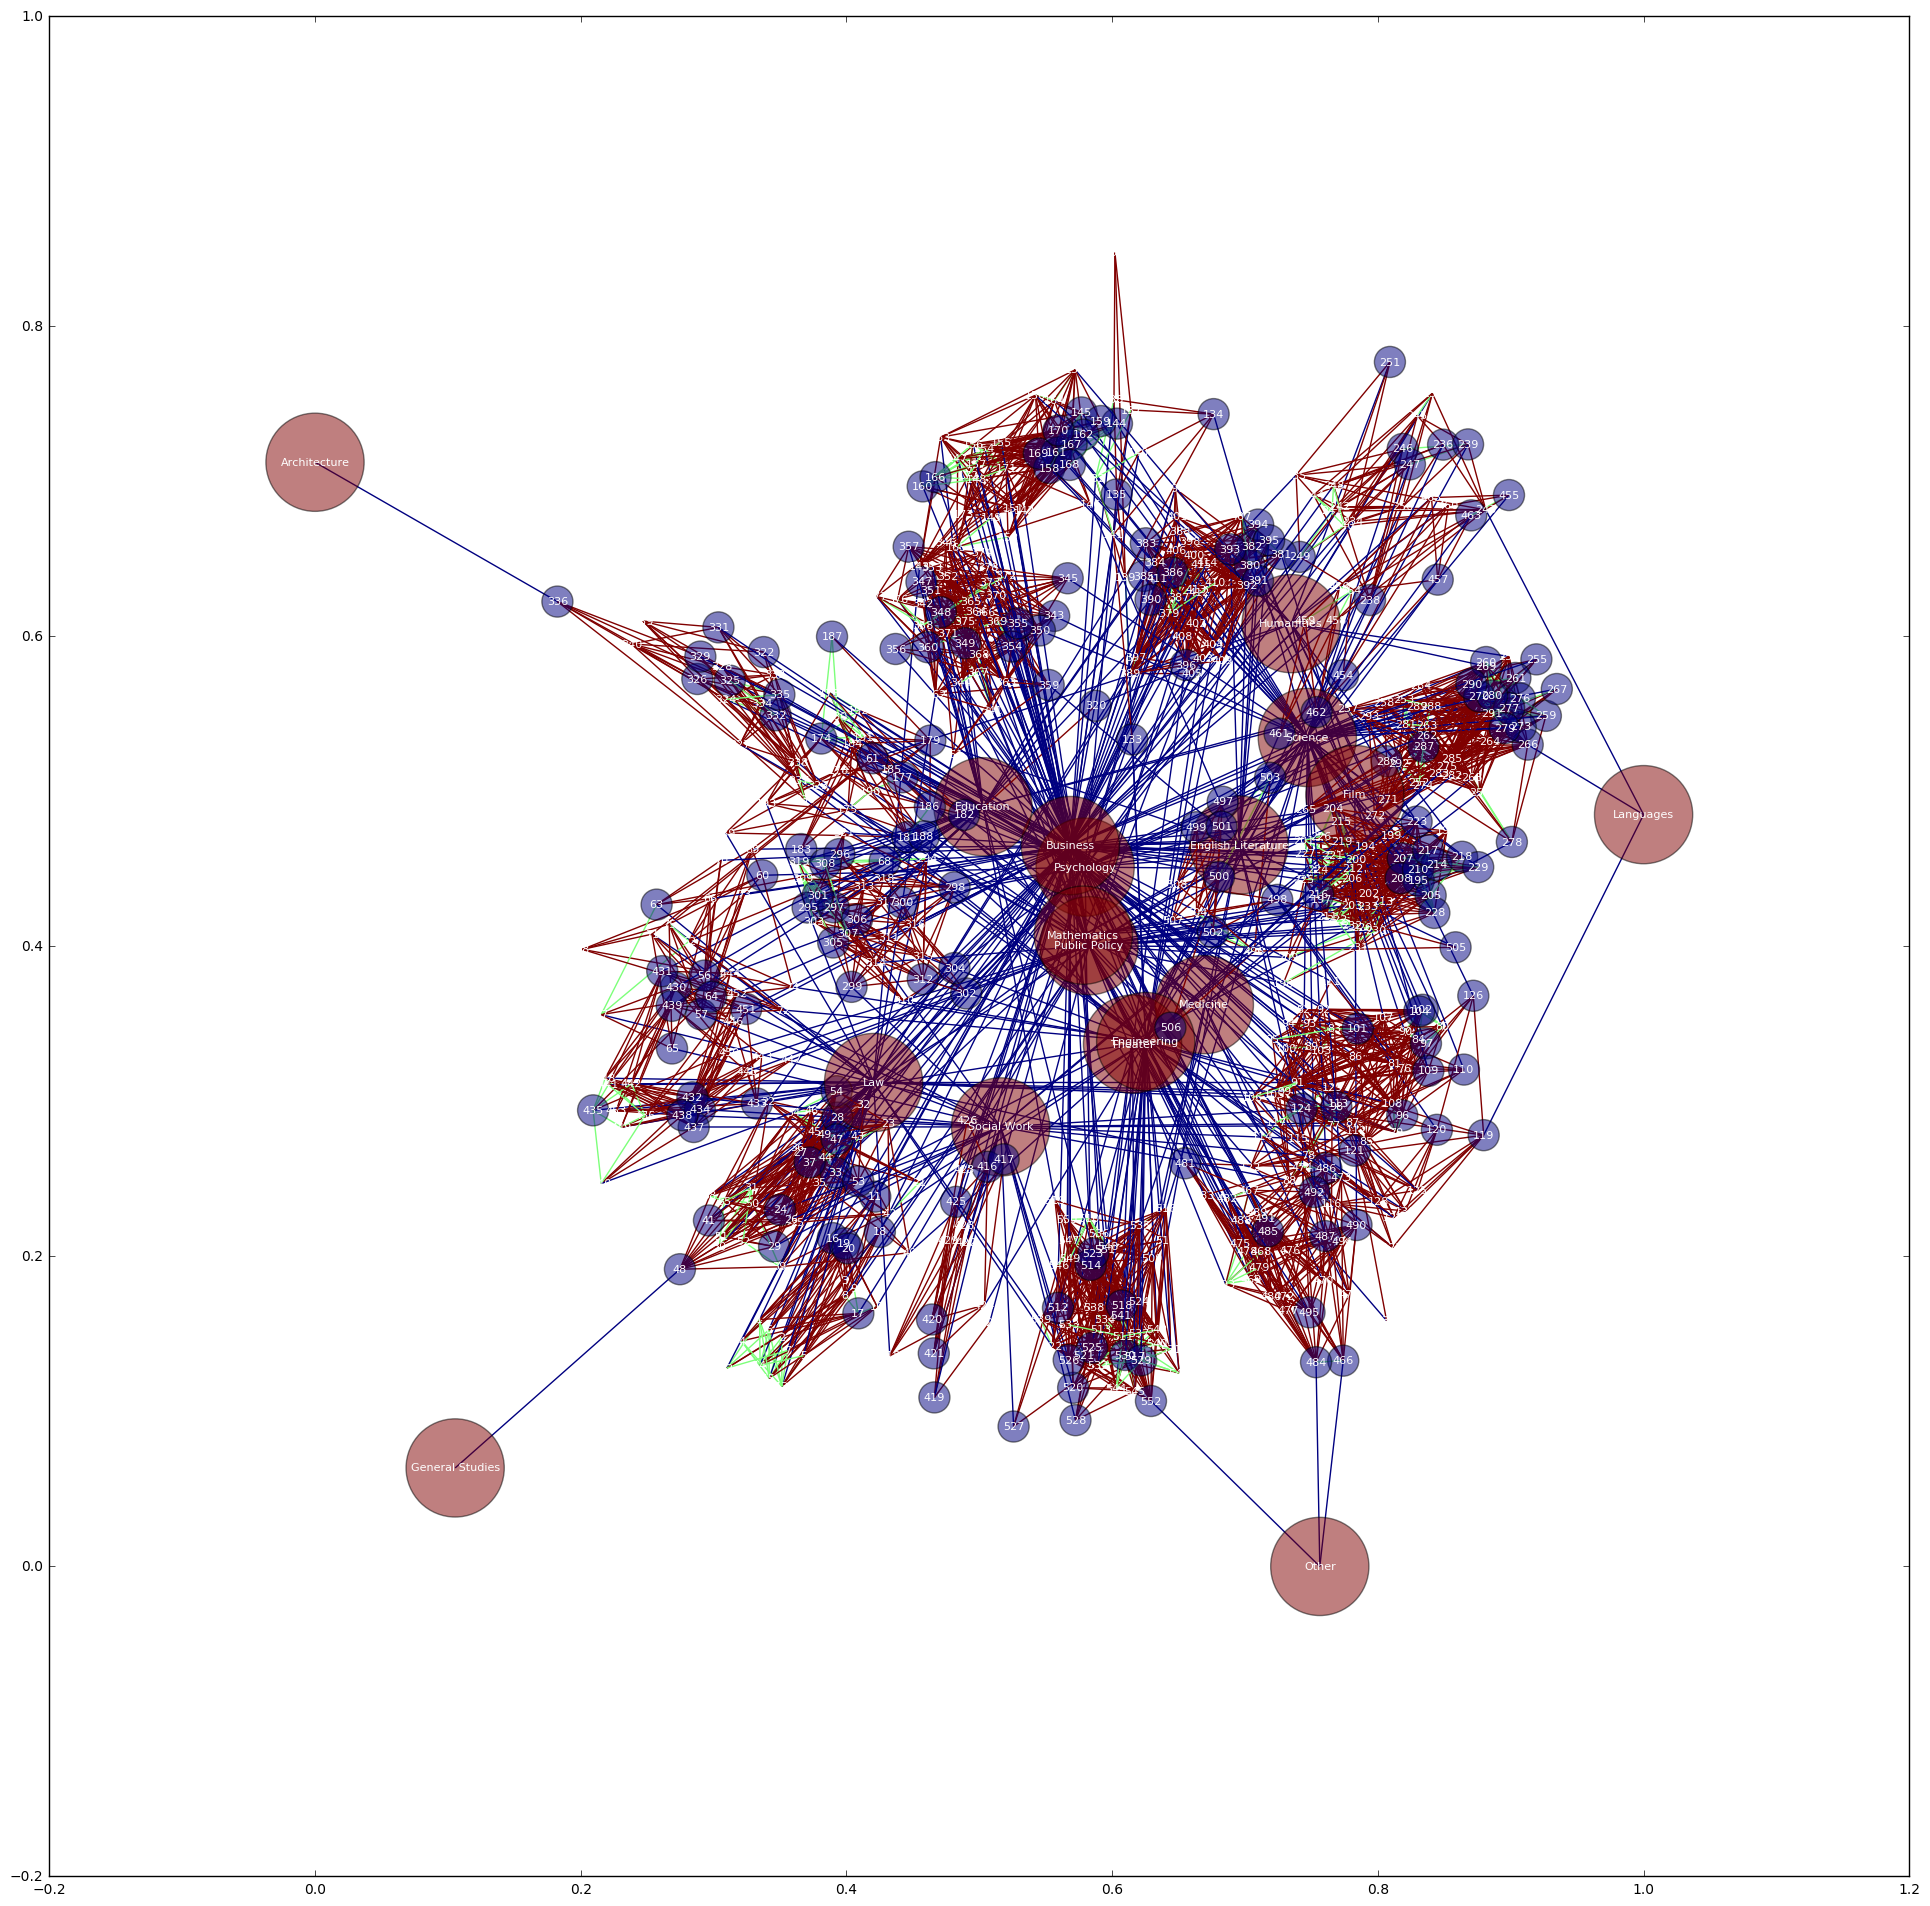

In [18]:
# draw the entire network
plt.figure(figsize=(24,24))
pos = nx.fruchterman_reingold_layout(W)

# in order to map degrees to nodes correctly
node_list,node_sizes = zip(*nx.get_node_attributes(W,'size').items())
node_sizes = np.array(node_sizes)

# for color coding nodes and edges
node_list,node_types = zip(*nx.get_node_attributes(W,'type').items())
edge_list,edge_types = zip(*nx.get_edge_attributes(W,'type').items())

nx.draw_networkx_nodes(W,pos,node_color=node_types,node_size=500*node_sizes,nodelist=node_list,alpha=.5)
nx.draw_networkx_labels(W,pos,font_color='white',font_size=8)
nx.draw_networkx_edges(W,pos,edge_color=edge_types,edgelist=edge_list)

# TODO: study/plot degree distribution, closures, and other graph properties
# ASK PROF MALIK: how to do degree distributions for a graph where edges mean different things?